<a href="https://colab.research.google.com/github/AbdLAzeem/AdaBoost-classifier/blob/main/MasterCard_Stock_Price_Prediction_Using_LSTM_%26_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MasterCard Stock **Price Prediction** Using **LSTM** & **GRU**

---




**Long Short Term Memory** (LSTM) is the **advanced** type of **RNN**, which was designed to **prevent** both **decaying** and **exploding** **gradient problems**. Just like RNN, LSTM has repeating modules, but the structure is different. **Instead of having a single layer of tanh, LSTM has four interacting layers** that communicate with each other.

**gated recurrent unit** (GRU) is a variation of LSTM as both have design similarities, and in some cases, they produce similar results. GRU uses an update gate and reset gate to solve the vanishing gradient problem. These gates decide what information is important and pass it to the output. The gates can be trained to store information from long ago, without vanishing over time or removing irrelevant information

---



use Kaggle’s MasterCard stock dataset from May-25-2006 to Oct-11-2021 and train the LSTM and GRU models to forecast the stock price.

"MasterCard Stock Data - Latest and Updated," available on Kaggle, provides comprehensive historical data on MasterCard's stock performance. The data is sourced from Yahoo! Finance and covers various aspects, including daily open, high, low, close prices, adjusted close prices, and trading volumes.

Key Features:
**Date Range**: The dataset includes stock data over an extensive period, allowing for in-depth historical analysis.
Variables:
**Open**: The price at which the stock opened on a given day.
**High**: The highest price reached during the trading day.
**Low**: The lowest price reached during the trading day.
**Close**: The final price at which the stock traded at the end of the day.
Adj Close: The adjusted closing price, accounting for dividends and stock splits.
Volume: The number of shares traded during the day.
Applications:
This dataset is ideal for financial analysis, including time series forecasting, trend analysis, and stock price prediction.

In [2]:
# Importing the libraries
import numpy as np                                    # data manipulation
import pandas as pd                                   # data manipulation
import matplotlib.pyplot as plt                       # visualization

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)


connect kaggle to colab to import the selected dataset online

In [3]:
# Install Kaggle API
!pip install kaggle

In [11]:
# Upload the Kaggle API key
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"abdelazeemnaser","key":"c3afbd2b5c5a737f2504701ddbf35dc6"}'}

In [13]:
# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle datasets download -d kalilurrahman/mastercard-stock-data-latest-and-updated

Dataset URL: https://www.kaggle.com/datasets/kalilurrahman/mastercard-stock-data-latest-and-updated
License(s): CC0-1.0
100% 154k/154k [00:00<00:00, 353kB/s]
100% 154k/154k [00:00<00:00, 353kB/s]


In [18]:
# Unzip the downloaded dataset
!unzip mastercard-stock-data-latest-and-updated.zip

Archive:  mastercard-stock-data-latest-and-updated.zip
  inflating: Mastercard_stock_history.csv  
  inflating: Mastercard_stock_info.csv  


now **dataset connected online** with kaggle without download the dataset locally

**Data Analysis**
In this part, we will import the MasterCard dataset by **adding** the Date column to the index and **converting** it to DateTime format. We will also **drop** irrelevant columns from the dataset as we are **only** **interested in** stock prices, volume, and date.

The dataset has Date as index and Open, High, Low, Close, and Volume as columns. It looks like we have successfully imported a cleaned dataset.

In [22]:
dataset = pd.read_csv("Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


The .describe() function helps us analyze the data in depth. Let’s focus on the High column as we are going to use it to train the model. We can also choose Close or Open columns for a model feature, but High makes more sense as it provides us information of how high the values of the share went on the given day.

In [23]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


The minimum stock price is $4.10, and the highest is $400.5. The mean is at $105.9 and the standard deviation $107.3, which means that **stocks have high variance**.

By using **.isna().sum()** we can determine the **missing values** in the dataset. It seems that the dataset has no missing values.

In [24]:
dataset.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0




---



lets take an over view graph for dataset

The **train_test_plot function** takes three arguments: **dataset**, **tstart**, and **tend** and plots a simple line graph. The tstart and tend are time limits in years. We can change these arguments to analyze specific periods. The **line plot **is divided into **two parts**: **train** and **test**. This will allow us to decide the distribution of the test dataset.

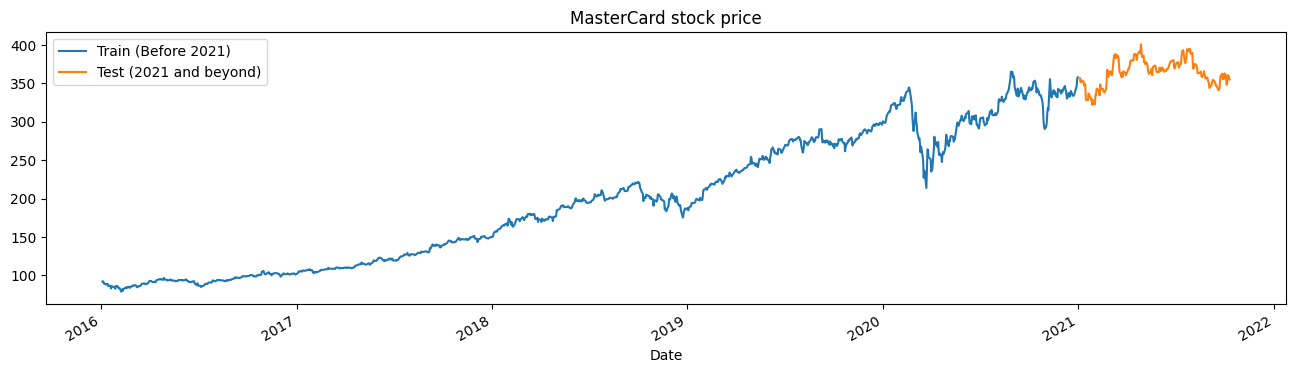

In [25]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

previous graph **discussion**:
MasterCard stock prices have been on the rise since 2016. It had a dip in the first quarter of 2020 but it gained a stable position in the latter half of the year. Our test dataset consists of one year, from 2021 to 2022, and the rest of the dataset is used for training

---



**Data Preprocessing**
The train_test_split function divides the dataset into two subsets: training_set and test_set

In [26]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)


use the **MinMaxScaler** function to standardize our training set, which will help us **avoid the outliers or anomalies**

In [27]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)




---



The split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train)

In this project, **we are using 60 n_steps**. We can also reduce or increase the number of steps to optimize model performance.

In [29]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)


We are working with **univariate series**, so the **number of features is one**, and we **need to reshape the X_train to fit on the LSTM model**. The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].

In [30]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)



---



**LSTM Model**The model consists of a **single hidden layer** of LSTM and **an output layer**. You can experiment with the number of units, as more units will give you better results. For this experiment, **we will set LSTM units to 125, tanh as activation, and set input size**

Finally, we will **compile** the model with an **RMSprop optimizer** and **mean square error as a loss function**

In [31]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 125)                 │          63,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training**:
The model will train on **50 epochs** with **32 batch sizes**. we can change the hyperparameters to reduce training time or improve the results. The model training was successfully completed with the best possible loss

In [34]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0411
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8668e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0021e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1354e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5816e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6354e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1683e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7931e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4288e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0839e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste



---



**Results**
We are going to **repeat preprocessing** and normalize the test set. First of all we will transform then split the dataset into samples, reshape it, predict, and inverse transform the predictions into standard form

In [35]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


The plot_predictions function will plot a real versus predicted line chart. This will help us visualize the difference between actual and predicted values.

The return_rmse function takes in test and predicted arguments and prints out the root mean square error (rmse) metric.

In [36]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

According to the line plot below, the single-layered LSTM model has performed well.

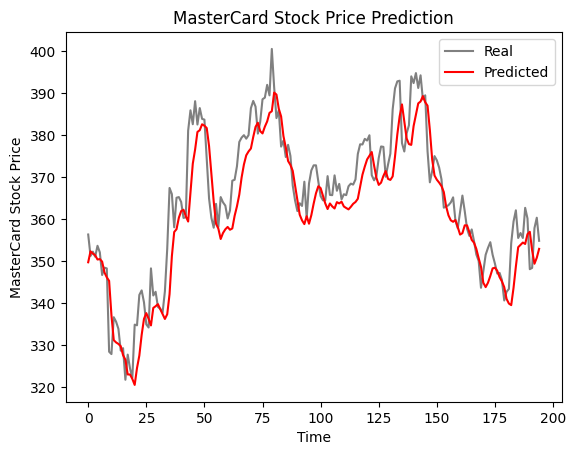

In [37]:
plot_predictions(test_set,predicted_stock_price)

The **results look promising as the model got 7.28 rmse on the test dataset**

In [39]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 7.28.




---



**GRU Model**
We are going to keep everything the same and just replace the LSTM layer with the GRU layer to properly compare the results. The model structure contains a single GRU layer with **125 units and an output layer**

In [42]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 125)                 │          48,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

**Train** GRU model

In [43]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0439
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2139e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6043e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5389e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1351e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1984e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6490e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3008e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9256e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5692e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1843e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0570e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s

The model has successfully **trained with 50 epochs and a batch size of 32**.

**Results**
As we can see, the real and predicted values are relatively close. The predicted line chart almost fits the actual values.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


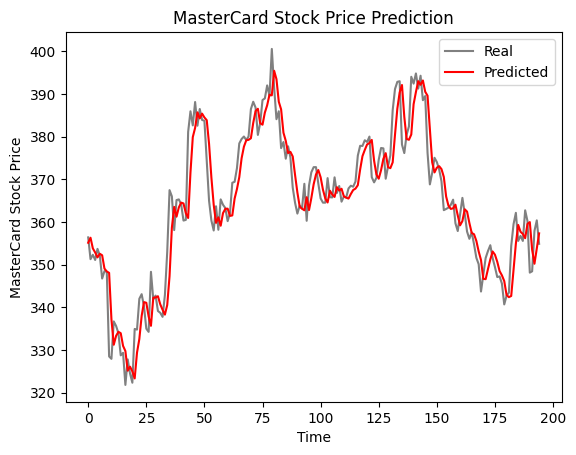

In [44]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [45]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.85.


GRU model got 5.85 rmse on the test dataset, which is an **improvement** from the LSTM model.



---



---



**Conclusion**
The results clearly show that the **GRU** model performed **better than LSTM**, with a similar structure and hyperparameters